In [1]:
import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from transformers import RobertaTokenizer

import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
import sys
sys.path.insert(0, '../src')
from metrics import metrics

In [4]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 70

In [5]:
hidden_size = 64

In [6]:
df = pd.read_csv('../data/internal/preprocessed.csv', index_col=0)

In [7]:
tokenizer = RobertaTokenizer.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier', cache_dir="../.cache/tokenizers/roberta_toxicity_classifier", padding_side='left', add_special_tokens=True)

In [8]:
VOCAB_SIZE = len(tokenizer)

In [9]:
tokenized_reference     = tokenizer(df['reference'].tolist(),   return_tensors="pt", padding='max_length', max_length=MAX_LENGTH)
tokenized_translation   = tokenizer(df['translation'].tolist(), return_tensors="pt", padding='max_length', max_length=MAX_LENGTH)

In [10]:
train_ratio = 0.8
val_test_ratio = 0.5

ref_train, ref_val, trn_train, trn_val = train_test_split(tokenized_reference['input_ids'], tokenized_translation['input_ids'], test_size=(1-train_ratio), random_state=42)
ref_val, ref_test, trn_val, trn_test = train_test_split(ref_val, trn_val, test_size=val_test_ratio, random_state=42)

In [11]:
batch_size = 38

train_dataset = torch.utils.data.TensorDataset(ref_train, trn_train)
validation_dataset = torch.utils.data.TensorDataset(ref_val, trn_val)
test_dataset = torch.utils.data.TensorDataset(ref_test, trn_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = nn.functional.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [14]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = nn.functional.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = nn.functional.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [15]:
import matplotlib.pyplot as plt

def showPlot(train_losses, test_losses, epoch):
    plt.figure()
    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(loc="upper right")
    plt.title(f'Losses on epoch {epoch}')
    plt.show()
    
def showScores(val_scores, epoch):
    plt.figure()
    plt.plot(val_scores, label='Validation score')
    plt.legend(loc="upper right")
    plt.title(f'BLUE scores on epoch {epoch}')
    plt.show()

In [16]:
def train_epoch(epoch, dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    encoder.train().to(device)
    decoder.train().to(device)

    total_loss = 0
    bar = tqdm(dataloader)
    
    bar.set_description(f'Train epoch {epoch}')
    
    for input_tensor, target_tensor in bar:
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()
        bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

In [17]:
def val_epoch(epoch, dataloader, encoder, decoder, criterion):

      total_loss = 0
      
      encoder.eval()
      decoder.eval()
    
      with torch.no_grad():
            bar = tqdm(dataloader)
            
            bar.set_description(f'Evaluation epoch {epoch}')
            
            decoded_targets = []
            decoded_predictions = []
            
            for input_tensor, target_tensor in bar:
                  input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

                  encoder_outputs, encoder_hidden = encoder(input_tensor)
                  decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

                  loss = criterion(
                  decoder_outputs.view(-1, decoder_outputs.size(-1)),
                  target_tensor.view(-1)
                  )
                  
                  total_loss += loss.item()

                  _, topi = decoder_outputs.topk(1, dim=2)
                  
                  decoded_ids = topi.squeeze()
                
                  # decoded_references = tokenizer.batch_decode(input_tensor, skip_special_tokens=True)
                  decoded_targets += tokenizer.batch_decode(target_tensor, skip_special_tokens=True)
                  decoded_predictions += tokenizer.batch_decode(decoded_ids, skip_special_tokens=True) 
                  
                  bar.set_postfix({'loss': loss.item()})
      
            blue = metrics.blue(decoded_predictions, decoded_targets)

      return total_loss / len(dataloader), blue

In [18]:
def train(train_dataloader, val_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=1, evaluate_every=1, plot_every=1, load_ckpt=False, load_ckpt_path=None, save_ckpt_path="best.pt"):
    
    if load_ckpt_path is None:
        load_ckpt_path = save_ckpt_path
    
    # best score for checkpointing
    best = 0.0
    train_losses = []
    val_losses = []
    val_scores = []
    
    first_epoch = 1
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    isCkptExists = os.path.isfile(load_ckpt_path)
    
    if (load_ckpt and not isCkptExists):
        print('Checkpoint file does not exist. Training model from scratch!')
    
    if (load_ckpt and isCkptExists):
        checkpoint = torch.load(load_ckpt_path)
        best = checkpoint['best_score']
        encoder.load_state_dict(checkpoint['encoder_state_dict'])
        decoder.load_state_dict(checkpoint['decoder_state_dict'])
        encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        train_losses = checkpoint['train_losses']
        val_scores = checkpoint['val_scores']
        val_losses = checkpoint['val_losses']
        first_epoch = checkpoint['epoch'] + 1
    
    print_train_loss_total = 0  # Reset every print_every
    print_val_loss_total = 0  # Reset every evaluate_every

    criterion = nn.NLLLoss()

    for epoch in range(first_epoch, n_epochs + first_epoch):            
            
        train_loss = train_epoch(epoch, train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += train_loss
        train_losses.append(train_loss)
        
        if epoch % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print(f'Train: (epoch {epoch}%) Loss: {print_train_loss_avg:.4f}')
        
        if epoch % evaluate_every == 0:    
            val_loss, val_score = val_epoch(epoch, val_dataloader, encoder, decoder, criterion)
            
            print_val_loss_total += val_loss
            val_losses.append(val_loss)
            val_scores.append(val_score)
            print_val_loss_avg = print_val_loss_total / print_every
            print_val_loss_total = 0
            
            if val_score > best:
                best = val_score
                torch.save({
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_scores': val_scores,
                'best_score': best,
                }, save_ckpt_path)
                  
            print(f'Evaluation: (epoch {epoch}) Loss: {print_val_loss_avg:.4f}, Score: {val_score:.4f}')

            
        if epoch % plot_every == 0:
            showPlot(train_losses, val_losses, epoch)
            showScores(val_scores, epoch)

In [19]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

Checkpoint file does not exist. Training model from scratch!


Train epoch 1: 100%|██████████| 2121/2121 [08:03<00:00,  4.39it/s, loss=0.678]


Train: (epoch 1%) Loss: 1.0898


Evaluation epoch 1: 100%|██████████| 266/266 [00:50<00:00,  5.25it/s, loss=0.961]


Evaluation: (epoch 1) Loss: 0.8350, Score: 0.7770


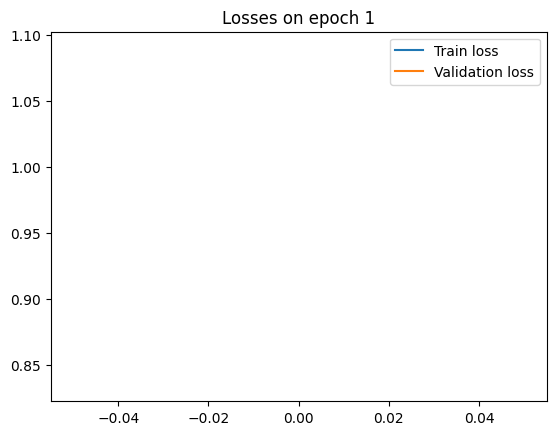

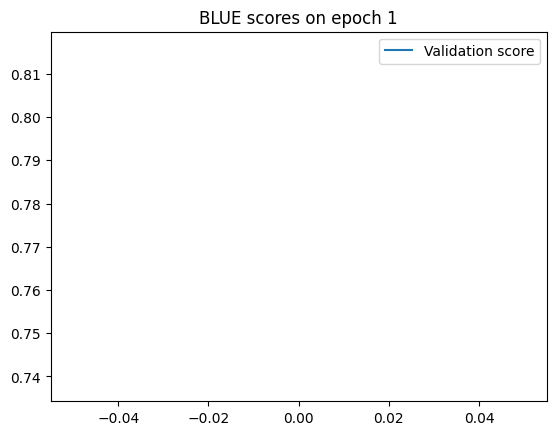

Train epoch 2: 100%|██████████| 2121/2121 [08:34<00:00,  4.12it/s, loss=0.577]


Train: (epoch 2%) Loss: 0.7624


Evaluation epoch 2: 100%|██████████| 266/266 [00:49<00:00,  5.42it/s, loss=0.778]


Evaluation: (epoch 2) Loss: 0.6937, Score: 4.0987


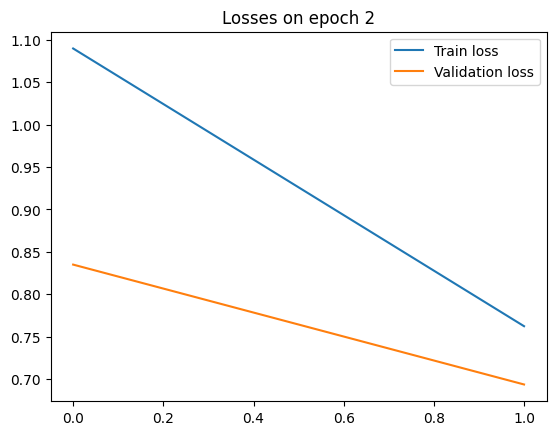

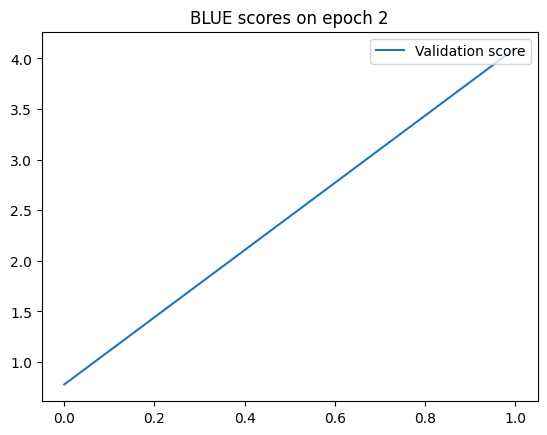

Train epoch 3: 100%|██████████| 2121/2121 [07:48<00:00,  4.53it/s, loss=0.537]


Train: (epoch 3%) Loss: 0.6511


Evaluation epoch 3: 100%|██████████| 266/266 [00:49<00:00,  5.43it/s, loss=0.669]


Evaluation: (epoch 3) Loss: 0.6288, Score: 8.0323


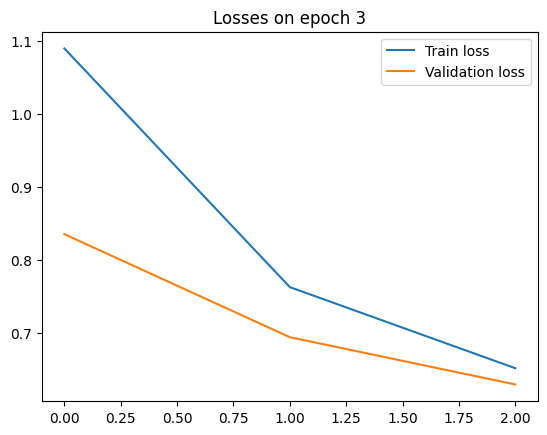

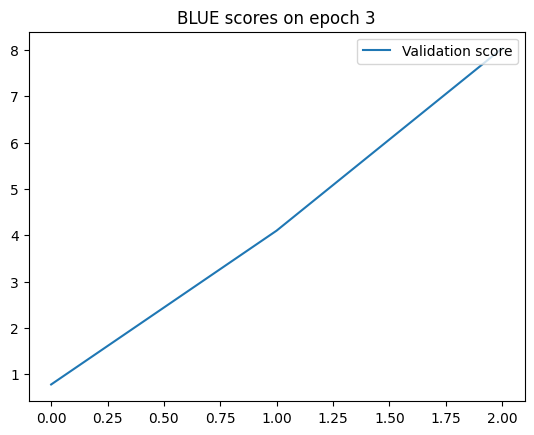

Train epoch 4: 100%|██████████| 2121/2121 [07:45<00:00,  4.55it/s, loss=0.619]


Train: (epoch 4%) Loss: 0.5962


Evaluation epoch 4: 100%|██████████| 266/266 [00:48<00:00,  5.47it/s, loss=0.608]


Evaluation: (epoch 4) Loss: 0.5931, Score: 11.2658


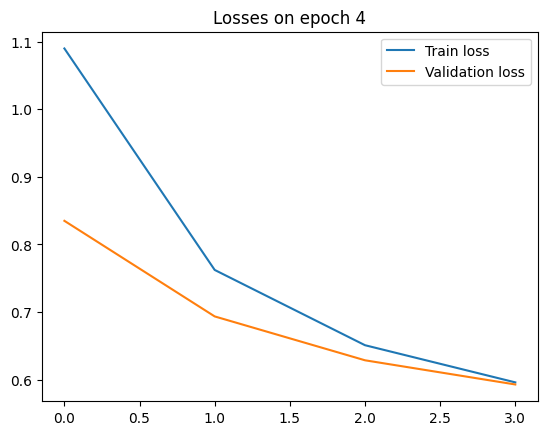

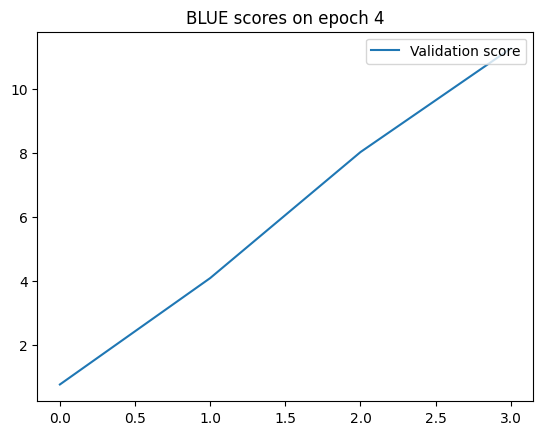

Train epoch 5: 100%|██████████| 2121/2121 [07:44<00:00,  4.56it/s, loss=0.416]


Train: (epoch 5%) Loss: 0.5570


Evaluation epoch 5: 100%|██████████| 266/266 [00:48<00:00,  5.47it/s, loss=0.567]


Evaluation: (epoch 5) Loss: 0.5663, Score: 14.1068


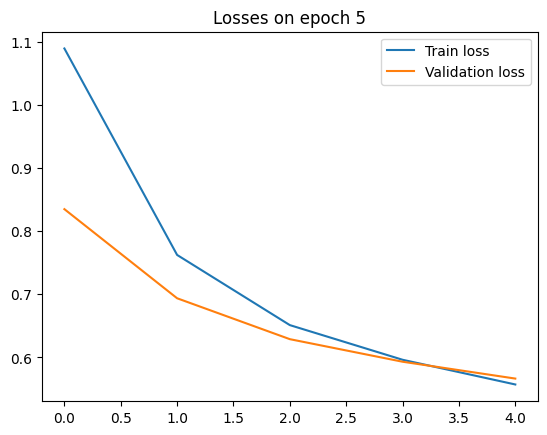

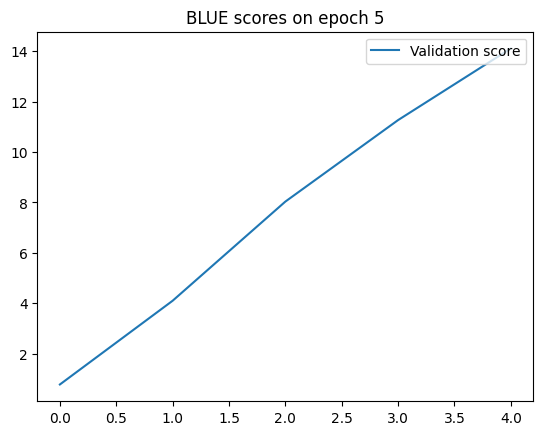

Train epoch 6: 100%|██████████| 2121/2121 [07:46<00:00,  4.54it/s, loss=0.566]


Train: (epoch 6%) Loss: 0.5265


Evaluation epoch 6: 100%|██████████| 266/266 [00:49<00:00,  5.40it/s, loss=0.55] 


Evaluation: (epoch 6) Loss: 0.5489, Score: 15.8676


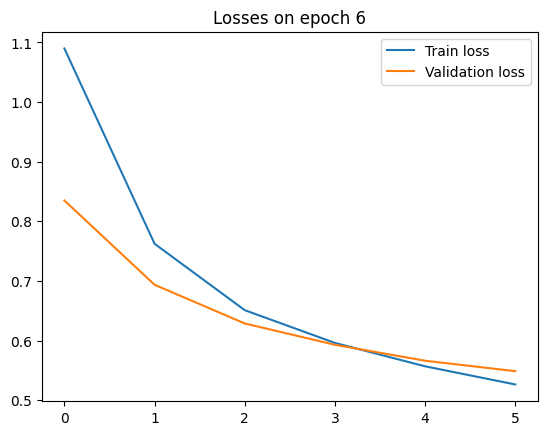

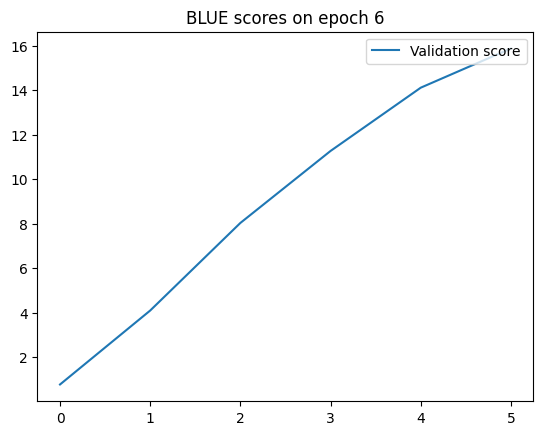

Train epoch 7: 100%|██████████| 2121/2121 [07:56<00:00,  4.45it/s, loss=0.391]


Train: (epoch 7%) Loss: 0.5009


Evaluation epoch 7: 100%|██████████| 266/266 [00:48<00:00,  5.50it/s, loss=0.539]


Evaluation: (epoch 7) Loss: 0.5330, Score: 17.8009


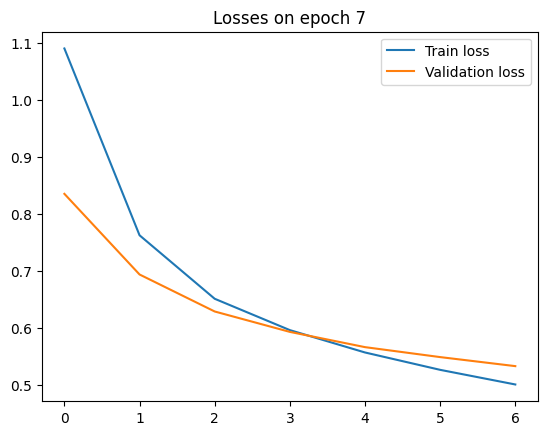

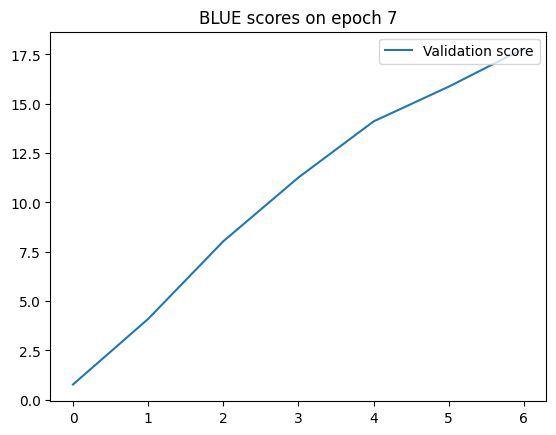

Train epoch 8: 100%|██████████| 2121/2121 [07:47<00:00,  4.54it/s, loss=0.486]


Train: (epoch 8%) Loss: 0.4787


Evaluation epoch 8: 100%|██████████| 266/266 [00:48<00:00,  5.47it/s, loss=0.488]


Evaluation: (epoch 8) Loss: 0.5178, Score: 19.5993


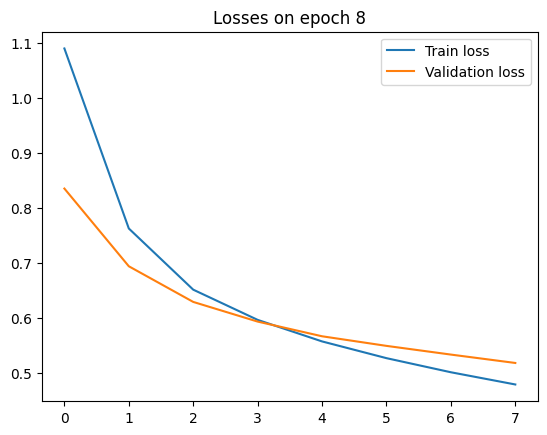

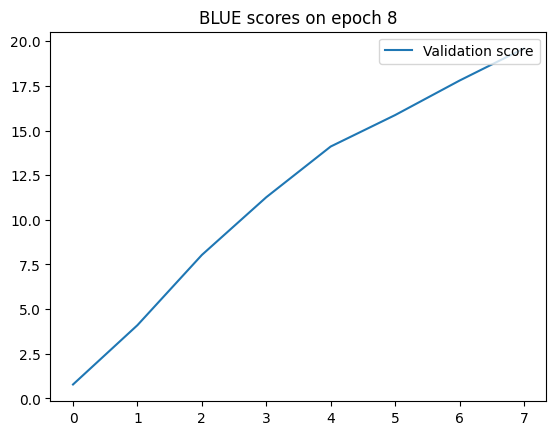

Train epoch 9: 100%|██████████| 2121/2121 [07:45<00:00,  4.56it/s, loss=0.406]


Train: (epoch 9%) Loss: 0.4601


Evaluation epoch 9: 100%|██████████| 266/266 [00:48<00:00,  5.48it/s, loss=0.506]


Evaluation: (epoch 9) Loss: 0.5096, Score: 20.5126


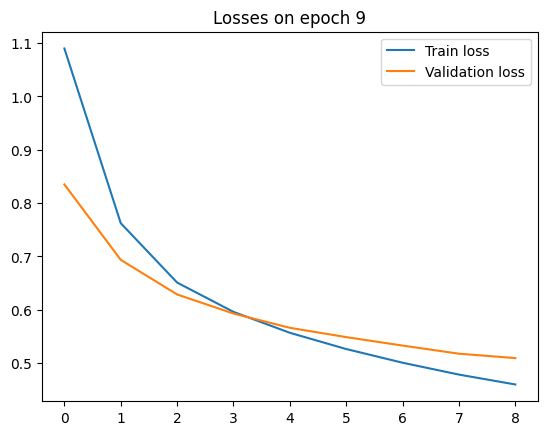

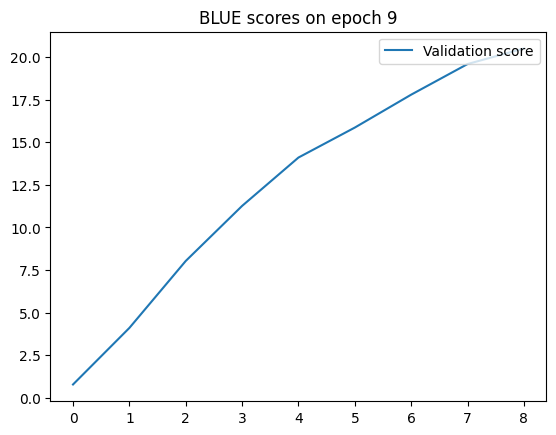

Train epoch 10: 100%|██████████| 2121/2121 [07:48<00:00,  4.53it/s, loss=0.547]


Train: (epoch 10%) Loss: 0.4433


Evaluation epoch 10: 100%|██████████| 266/266 [00:48<00:00,  5.47it/s, loss=0.48] 


Evaluation: (epoch 10) Loss: 0.4998, Score: 21.8392


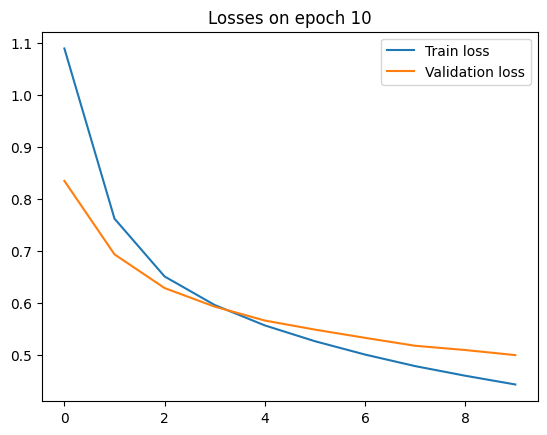

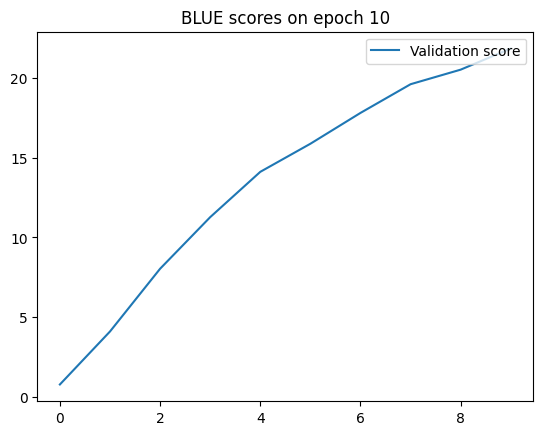

Train epoch 11: 100%|██████████| 2121/2121 [07:54<00:00,  4.47it/s, loss=0.34] 


Train: (epoch 11%) Loss: 0.4285


Evaluation epoch 11: 100%|██████████| 266/266 [00:48<00:00,  5.48it/s, loss=0.469]


Evaluation: (epoch 11) Loss: 0.4918, Score: 22.7013


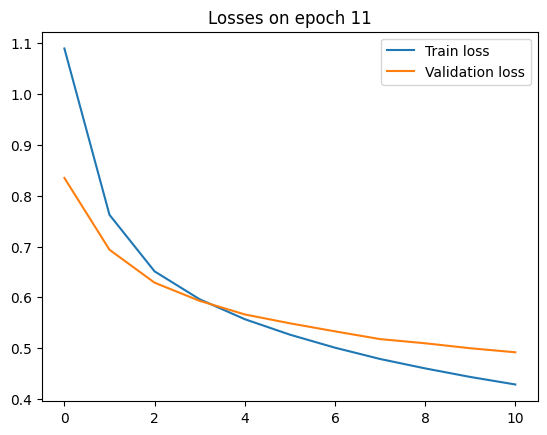

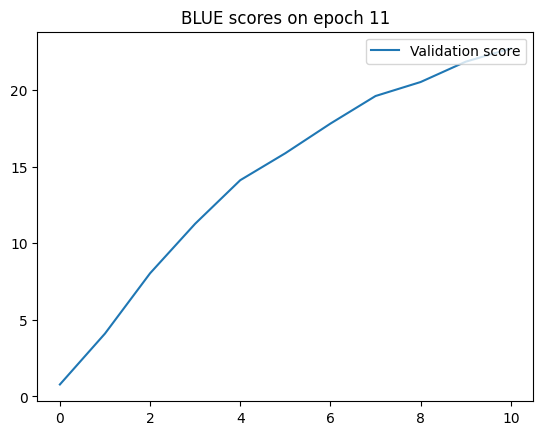

Train epoch 12: 100%|██████████| 2121/2121 [07:47<00:00,  4.53it/s, loss=0.327]


Train: (epoch 12%) Loss: 0.4153


Evaluation epoch 12: 100%|██████████| 266/266 [00:49<00:00,  5.33it/s, loss=0.475]


Evaluation: (epoch 12) Loss: 0.4835, Score: 23.3879


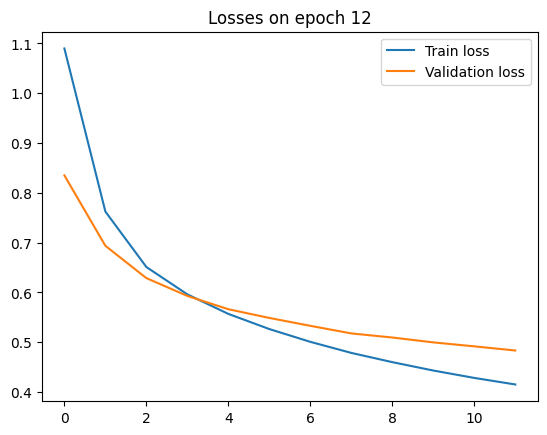

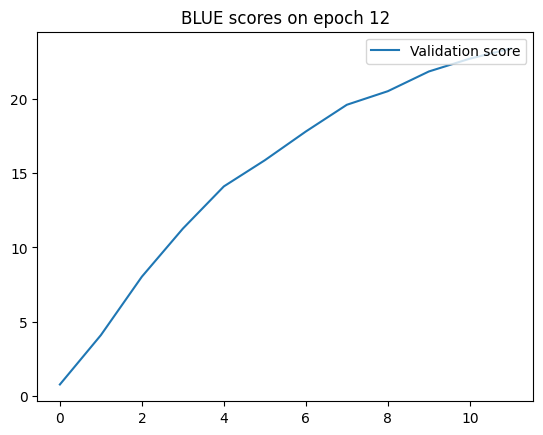

Train epoch 13: 100%|██████████| 2121/2121 [08:05<00:00,  4.37it/s, loss=0.389]


Train: (epoch 13%) Loss: 0.4036


Evaluation epoch 13: 100%|██████████| 266/266 [00:49<00:00,  5.41it/s, loss=0.452]


Evaluation: (epoch 13) Loss: 0.4797, Score: 23.7404


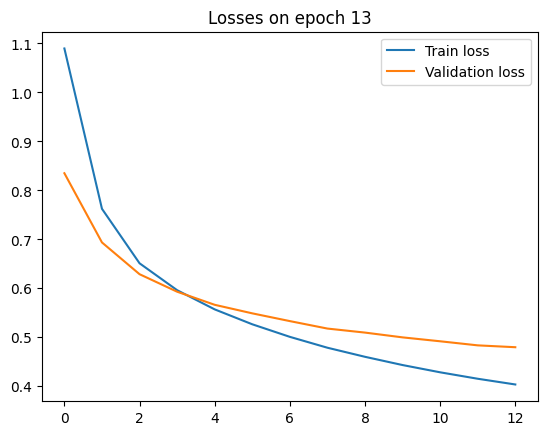

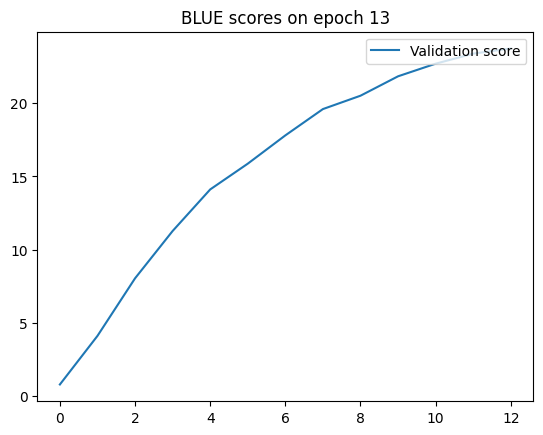

Train epoch 14: 100%|██████████| 2121/2121 [07:48<00:00,  4.53it/s, loss=0.284]


Train: (epoch 14%) Loss: 0.3927


Evaluation epoch 14: 100%|██████████| 266/266 [00:47<00:00,  5.57it/s, loss=0.456]


Evaluation: (epoch 14) Loss: 0.4791, Score: 24.3419


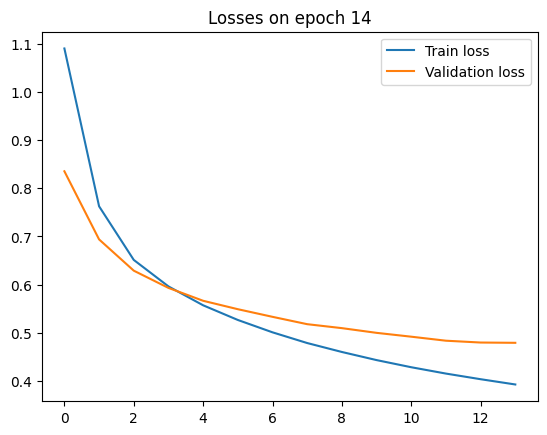

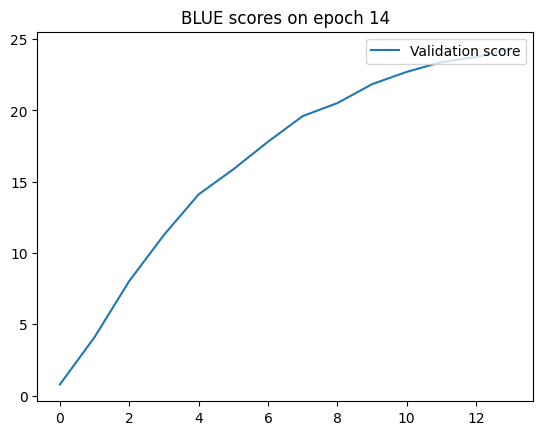

Train epoch 15: 100%|██████████| 2121/2121 [07:46<00:00,  4.55it/s, loss=0.395]


Train: (epoch 15%) Loss: 0.3828


Evaluation epoch 15: 100%|██████████| 266/266 [00:48<00:00,  5.50it/s, loss=0.436]


Evaluation: (epoch 15) Loss: 0.4711, Score: 24.9824


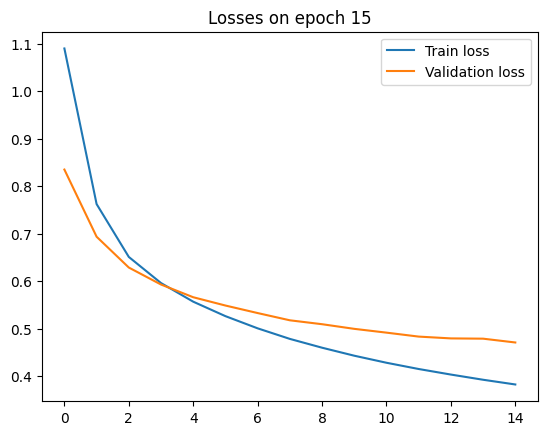

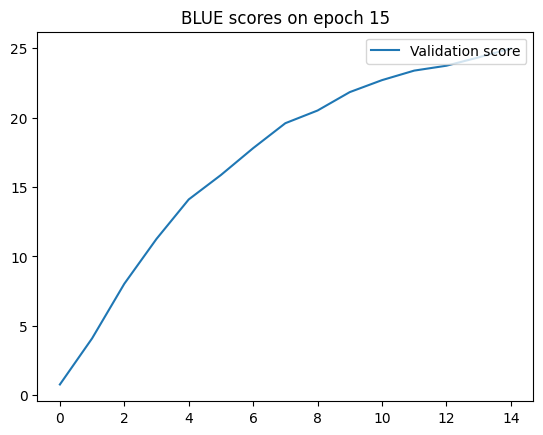

Train epoch 16: 100%|██████████| 2121/2121 [07:57<00:00,  4.44it/s, loss=0.317]


Train: (epoch 16%) Loss: 0.3747


Evaluation epoch 16: 100%|██████████| 266/266 [00:48<00:00,  5.45it/s, loss=0.418]


Evaluation: (epoch 16) Loss: 0.4859, Score: 24.2756


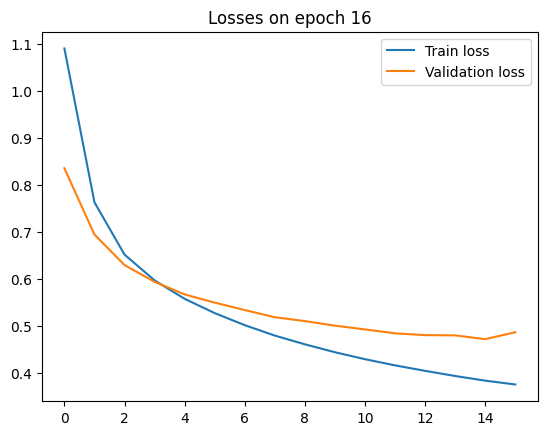

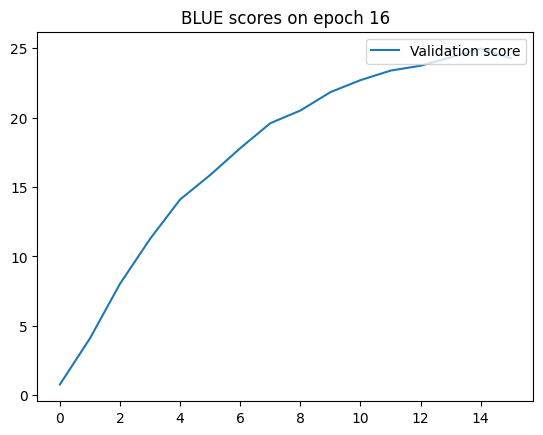

Train epoch 17: 100%|██████████| 2121/2121 [07:51<00:00,  4.50it/s, loss=0.238]


Train: (epoch 17%) Loss: 0.3660


Evaluation epoch 17: 100%|██████████| 266/266 [00:48<00:00,  5.53it/s, loss=0.431]


Evaluation: (epoch 17) Loss: 0.4671, Score: 25.5936


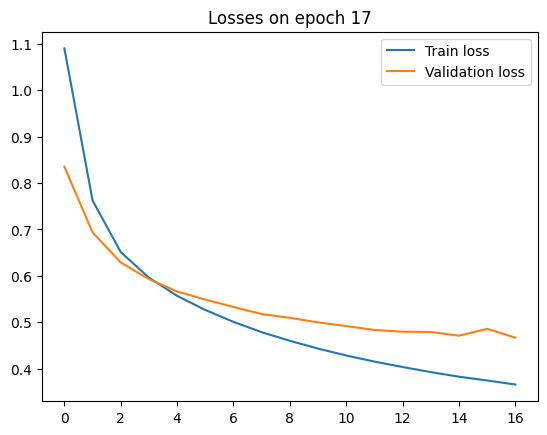

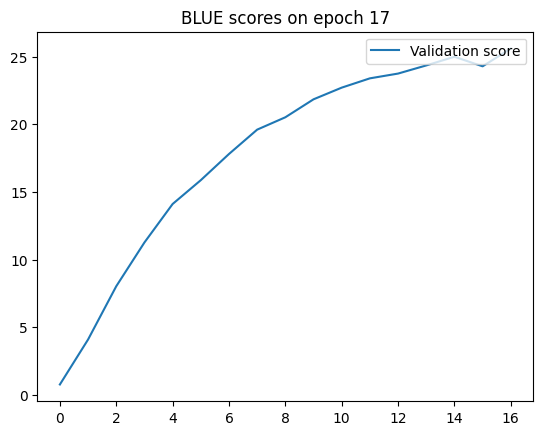

Train epoch 18: 100%|██████████| 2121/2121 [07:53<00:00,  4.48it/s, loss=0.337]


Train: (epoch 18%) Loss: 0.3585


Evaluation epoch 18: 100%|██████████| 266/266 [00:49<00:00,  5.43it/s, loss=0.431]


Evaluation: (epoch 18) Loss: 0.4695, Score: 25.6839


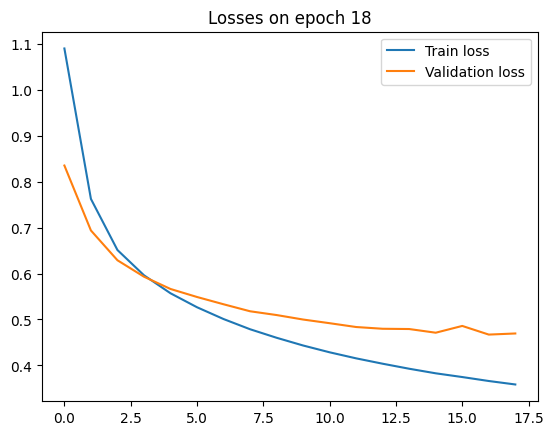

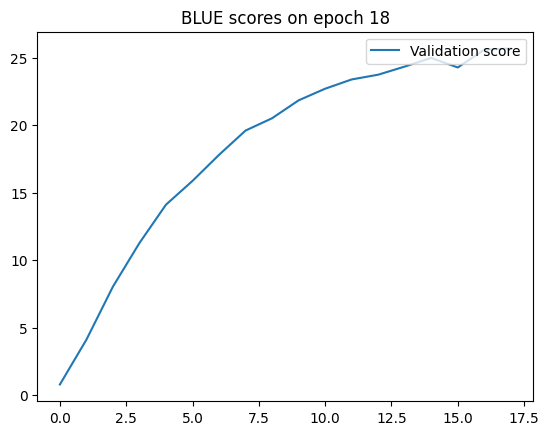

Train epoch 19: 100%|██████████| 2121/2121 [07:55<00:00,  4.46it/s, loss=0.27] 


Train: (epoch 19%) Loss: 0.3521


Evaluation epoch 19: 100%|██████████| 266/266 [00:48<00:00,  5.44it/s, loss=0.418]


Evaluation: (epoch 19) Loss: 0.4704, Score: 25.1573


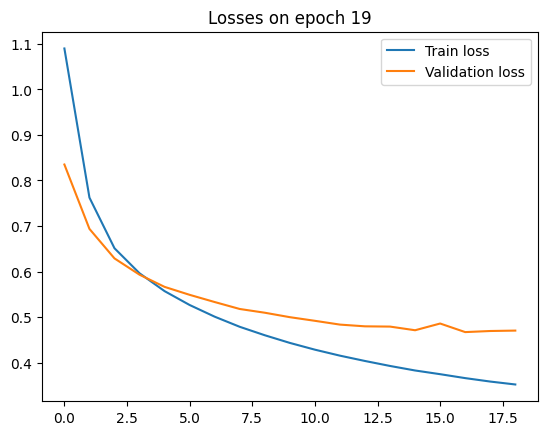

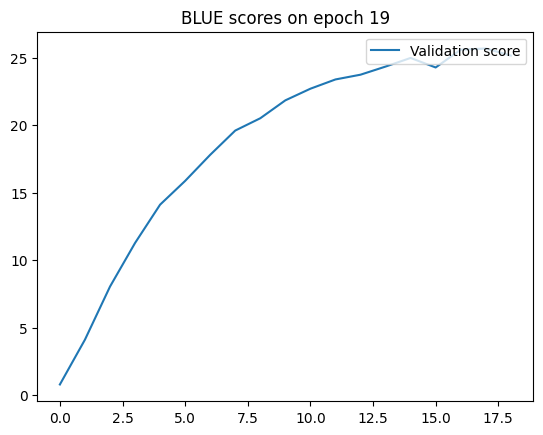

Train epoch 20: 100%|██████████| 2121/2121 [07:49<00:00,  4.52it/s, loss=0.291]


Train: (epoch 20%) Loss: 0.3451


Evaluation epoch 20: 100%|██████████| 266/266 [00:48<00:00,  5.51it/s, loss=0.398]


Evaluation: (epoch 20) Loss: 0.4615, Score: 26.1066


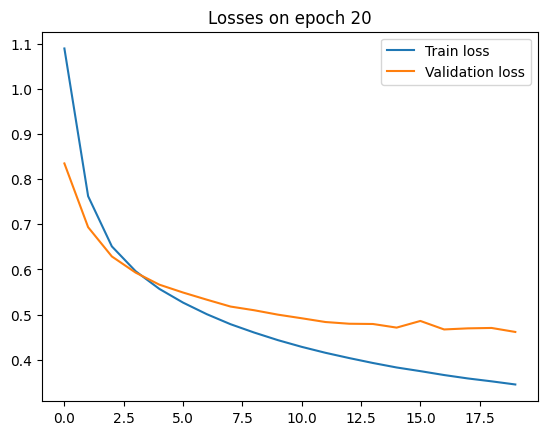

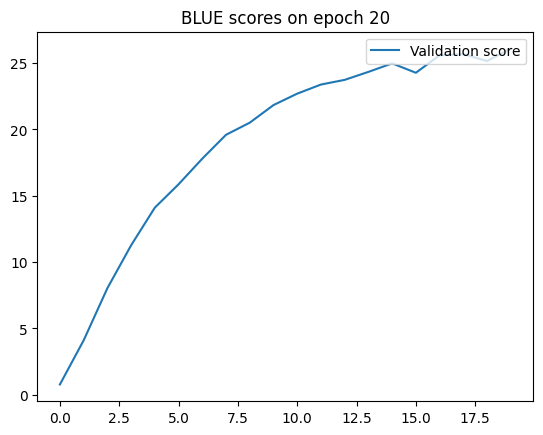

In [20]:
encoder = EncoderRNN(VOCAB_SIZE, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, VOCAB_SIZE).to(device)

train(train_dataloader, validation_dataloader, encoder, decoder, 20, load_ckpt=True, save_ckpt_path="../models/transformer/best.pt")

In [22]:
encoder = EncoderRNN(VOCAB_SIZE, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, VOCAB_SIZE).to(device)

checkpoint = torch.load('../models/transformer/best.pt')

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

<All keys matched successfully>

In [23]:
def test_model(dataloader, encoder, decoder):      
      encoder.eval()
      decoder.eval()
    
      with torch.no_grad():
            bar = tqdm(dataloader, desc='Evaluation')
            
            decoded_targets = []
            decoded_predictions = []
            
            for input_tensor, target_tensor in bar:
                  input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

                  encoder_outputs, encoder_hidden = encoder(input_tensor)
                  decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
                  
                  _, topi = decoder_outputs.topk(1, dim=2)
                  
                  decoded_ids = topi.squeeze()
                
                  decoded_targets += tokenizer.batch_decode(target_tensor, skip_special_tokens=True)
                  decoded_predictions += tokenizer.batch_decode(decoded_ids, skip_special_tokens=True) 
                  
            blue_score = metrics.blue(decoded_predictions, decoded_targets)
            similarity_score = metrics.content_similarity({'device':device, 'batch_size':512}, decoded_predictions, decoded_targets)
            fluency_score = metrics.fluency({'device':device, 'batch_size':256}, decoded_predictions)
            sta_score = metrics.style_transfer_accuracy({'device':device, 'batch_size':256}, decoded_predictions)
 
      return blue_score, similarity_score, fluency_score, sta_score

In [24]:
blue_score, similarity_score, fluency_score, sta_score = test_model(test_dataloader, encoder, decoder)

100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
print('BLUE:', blue_score)
print('Similarity:', similarity_score)
print('Fluency:', fluency_score)
print('STA:', sta_score)

BLUE: 26.091949023983393
Similarity: 0.716261088848114
Fluency: 0.3518398404121399
STA: 9.926544589689001e-05
